# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
sns.set

<function seaborn.rcmod.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)>

Load the environment app to run locally

In [2]:
env = UnityEnvironment(file_name='reacher_single.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. Training the Agent

The Agent and replay Buffer are imported from the ddpg_agent.py file.
In order to train multiple agents via MADDPG, the memory is delocated from the individual agents and instantiated globaly.

The Parameters for the memory and agent were adjusted by trial and error and resulted in the implemented values.

Sadly, the multi-agent configuration was unable to use the GPU acceleration, making it impossible for me to run.

In [5]:
# Load the Agent from the ddpg_agent file
from ddpg_agent import Agent, ReplayBuffer
from collections import deque
import torch

import matplotlib.pyplot as plt
%matplotlib inline

# initialize the agent and the environment
#[Agent(state_size=state_size, action_size=action_size, random_seed=0, memory = memory, critic_target = critic_target) for count in range(num_agents)]

# Initialize agent and shared memory (for multi-agent use)
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
random_seed = 1

memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, memory = memory)



In [6]:
#training function
def ddpg(n_episodes=700, max_t=1000, PRINT_EVERY=20):
    scores_deque = deque(maxlen=100)
    scores_list = []
    max_score = -np.Inf
    eps = tnrange(1, n_episodes+1)                             # counter for episodes (for time eval)
    for i_episode in eps:
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        steps = tnrange(max_t, leave = False)                  # counter for steps (for time eval)
        for t in steps:
            steps.set_description("mean score is %f" % np.mean(scores_deque)) # write last score to counter
            #print(t)
            actions = agent.act(states)                        # calculate next action with actor net
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            
            if np.any(dones):
                break
                
        score = np.mean(scores)                                # save scores for evaluation
        scores_deque.append(score)
        scores_list.append(score)
        #steps.set_description("mean score is %f" % np.mean(scores_deque))
        #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % PRINT_EVERY == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if np.mean(scores_deque) >= 31:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            #break
        
    return scores_list

In [7]:
# train the iteration of the agent and get scores
%time scores = ddpg()

/anaconda3/envs/drlnd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/drlnd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 20	Average Score: 0.87


Episode 40	Average Score: 1.46


Episode 60	Average Score: 2.42


Episode 80	Average Score: 3.08


Episode 100	Average Score: 3.82


Episode 120	Average Score: 5.23


Episode 140	Average Score: 7.34


Episode 160	Average Score: 9.40


Episode 180	Average Score: 11.90


Episode 200	Average Score: 15.24


Episode 220	Average Score: 19.11


Episode 240	Average Score: 22.87


Episode 260	Average Score: 26.60


Episode 280	Average Score: 29.49


Episode 300	Average Score: 31.00

Environment solved in 300 episodes!	Average Score: 31.00



Environment solved in 301 episodes!	Average Score: 31.14



Environment solved in 302 episodes!	Average Score: 31.24



Environment solved in 303 episodes!	Average Score: 31.41



Environment solved in 304 episodes!	Average Score: 31.43



Environment solved in 305 episodes!	Average Score: 31.39



Environment solved in 306 episodes!	Average Score: 31.36



Environment solved in 307 episodes!	Average Score: 31.33



Environment solved in 308 episodes!	Average Score: 31.28



Environment solved in 309 episodes!	Average Score: 31.34



Environment solved in 310 episodes!	Average Score: 31.37



Environment solved in 311 episodes!	Average Score: 31.38



Environment solved in 312 episodes!	Average Score: 31.33



Environment solved in 313 episodes!	Average Score: 31.48



Environment solved in 314 episodes!	Average Score: 31.52



Environment solved in 315 episodes!	Average Score: 31.40



Environment solved in 316 episodes!	Average Score: 31.36



Environment solved in 317 episodes!	Average Score: 31.38



Environment solved in 318 episodes!	Average Score: 31.31



Environment solved in 319 episodes!	Average Score: 31.35


Episode 320	Average Score: 31.34

Environment solved in 320 episodes!	Average Score: 31.34



Environment solved in 321 episodes!	Average Score: 31.36



Environment solved in 322 episodes!	Average Score: 31.36



Environment solved in 323 episodes!	Average Score: 31.38



Environment solved in 324 episodes!	Average Score: 31.49



Environment solved in 325 episodes!	Average Score: 31.56



Environment solved in 326 episodes!	Average Score: 31.66



Environment solved in 327 episodes!	Average Score: 31.73



Environment solved in 328 episodes!	Average Score: 31.72



Environment solved in 329 episodes!	Average Score: 31.56



Environment solved in 330 episodes!	Average Score: 31.75



Environment solved in 331 episodes!	Average Score: 31.78



Environment solved in 332 episodes!	Average Score: 31.77



Environment solved in 333 episodes!	Average Score: 31.72



Environment solved in 334 episodes!	Average Score: 31.72



Environment solved in 335 episodes!	Average Score: 31.73



Environment solved in 336 episodes!	Average Score: 31.70



Environment solved in 337 episodes!	Average Score: 31.70



Environment solved in 338 episodes!	Average Score: 31.70



Environment solved in 339 episodes!	Average Score: 31.80


Episode 340	Average Score: 31.84

Environment solved in 340 episodes!	Average Score: 31.84



Environment solved in 341 episodes!	Average Score: 31.83



Environment solved in 342 episodes!	Average Score: 31.84



Environment solved in 343 episodes!	Average Score: 31.82



Environment solved in 344 episodes!	Average Score: 31.81



Environment solved in 345 episodes!	Average Score: 31.81



Environment solved in 346 episodes!	Average Score: 31.80



Environment solved in 347 episodes!	Average Score: 31.78



Environment solved in 348 episodes!	Average Score: 31.68



Environment solved in 349 episodes!	Average Score: 31.69



Environment solved in 350 episodes!	Average Score: 31.72



Environment solved in 351 episodes!	Average Score: 31.71



Environment solved in 352 episodes!	Average Score: 31.74



Environment solved in 353 episodes!	Average Score: 31.80



Environment solved in 354 episodes!	Average Score: 31.77



Environment solved in 355 episodes!	Average Score: 31.63



Environment solved in 356 episodes!	Average Score: 31.64



Environment solved in 357 episodes!	Average Score: 31.67



Environment solved in 358 episodes!	Average Score: 31.73



Environment solved in 359 episodes!	Average Score: 31.67


Episode 360	Average Score: 31.64

Environment solved in 360 episodes!	Average Score: 31.64



Environment solved in 361 episodes!	Average Score: 31.59



Environment solved in 362 episodes!	Average Score: 31.49



Environment solved in 363 episodes!	Average Score: 31.60



Environment solved in 364 episodes!	Average Score: 31.60



Environment solved in 365 episodes!	Average Score: 31.64



Environment solved in 366 episodes!	Average Score: 31.71



Environment solved in 367 episodes!	Average Score: 31.72



Environment solved in 368 episodes!	Average Score: 31.86



Environment solved in 369 episodes!	Average Score: 31.78



Environment solved in 370 episodes!	Average Score: 31.89



Environment solved in 371 episodes!	Average Score: 31.99



Environment solved in 372 episodes!	Average Score: 32.03



Environment solved in 373 episodes!	Average Score: 32.07



Environment solved in 374 episodes!	Average Score: 32.09



Environment solved in 375 episodes!	Average Score: 32.14



Environment solved in 376 episodes!	Average Score: 32.17



Environment solved in 377 episodes!	Average Score: 32.26



Environment solved in 378 episodes!	Average Score: 32.28



Environment solved in 379 episodes!	Average Score: 32.32


Episode 380	Average Score: 32.40

Environment solved in 380 episodes!	Average Score: 32.40



Environment solved in 381 episodes!	Average Score: 32.39



Environment solved in 382 episodes!	Average Score: 32.47



Environment solved in 383 episodes!	Average Score: 32.50



Environment solved in 384 episodes!	Average Score: 32.56



Environment solved in 385 episodes!	Average Score: 32.63



Environment solved in 386 episodes!	Average Score: 32.61



Environment solved in 387 episodes!	Average Score: 32.65



Environment solved in 388 episodes!	Average Score: 32.68



Environment solved in 389 episodes!	Average Score: 32.76



Environment solved in 390 episodes!	Average Score: 32.84



Environment solved in 391 episodes!	Average Score: 32.88



Environment solved in 392 episodes!	Average Score: 33.04



Environment solved in 393 episodes!	Average Score: 33.05



Environment solved in 394 episodes!	Average Score: 33.09



Environment solved in 395 episodes!	Average Score: 33.21



Environment solved in 396 episodes!	Average Score: 33.25



Environment solved in 397 episodes!	Average Score: 33.18



Environment solved in 398 episodes!	Average Score: 33.23



Environment solved in 399 episodes!	Average Score: 33.22


Episode 400	Average Score: 33.17

Environment solved in 400 episodes!	Average Score: 33.17



Environment solved in 401 episodes!	Average Score: 33.24



Environment solved in 402 episodes!	Average Score: 33.27



Environment solved in 403 episodes!	Average Score: 33.27



Environment solved in 404 episodes!	Average Score: 33.27



Environment solved in 405 episodes!	Average Score: 33.41



Environment solved in 406 episodes!	Average Score: 33.52



Environment solved in 407 episodes!	Average Score: 33.57



Environment solved in 408 episodes!	Average Score: 33.77



Environment solved in 409 episodes!	Average Score: 33.86



Environment solved in 410 episodes!	Average Score: 33.95



Environment solved in 411 episodes!	Average Score: 34.04



Environment solved in 412 episodes!	Average Score: 34.09



Environment solved in 413 episodes!	Average Score: 34.12



Environment solved in 414 episodes!	Average Score: 34.19



Environment solved in 415 episodes!	Average Score: 34.46



Environment solved in 416 episodes!	Average Score: 34.47



Environment solved in 417 episodes!	Average Score: 34.54



Environment solved in 418 episodes!	Average Score: 34.71



Environment solved in 419 episodes!	Average Score: 34.72


Episode 420	Average Score: 34.62

Environment solved in 420 episodes!	Average Score: 34.62



Environment solved in 421 episodes!	Average Score: 34.63



Environment solved in 422 episodes!	Average Score: 34.62



Environment solved in 423 episodes!	Average Score: 34.65



Environment solved in 424 episodes!	Average Score: 34.64



Environment solved in 425 episodes!	Average Score: 34.59



Environment solved in 426 episodes!	Average Score: 34.58



Environment solved in 427 episodes!	Average Score: 34.53



Environment solved in 428 episodes!	Average Score: 34.64



Environment solved in 429 episodes!	Average Score: 34.80



Environment solved in 430 episodes!	Average Score: 34.76



Environment solved in 431 episodes!	Average Score: 34.76



Environment solved in 432 episodes!	Average Score: 34.79



Environment solved in 433 episodes!	Average Score: 34.78



Environment solved in 434 episodes!	Average Score: 34.79



Environment solved in 435 episodes!	Average Score: 34.77



Environment solved in 436 episodes!	Average Score: 34.80



Environment solved in 437 episodes!	Average Score: 34.79



Environment solved in 438 episodes!	Average Score: 34.81



Environment solved in 439 episodes!	Average Score: 34.76


Episode 440	Average Score: 34.74

Environment solved in 440 episodes!	Average Score: 34.74



Environment solved in 441 episodes!	Average Score: 34.64



Environment solved in 442 episodes!	Average Score: 34.73



Environment solved in 443 episodes!	Average Score: 34.77



Environment solved in 444 episodes!	Average Score: 34.73



Environment solved in 445 episodes!	Average Score: 34.69



Environment solved in 446 episodes!	Average Score: 34.78



Environment solved in 447 episodes!	Average Score: 34.82



Environment solved in 448 episodes!	Average Score: 34.85



Environment solved in 449 episodes!	Average Score: 34.86



Environment solved in 450 episodes!	Average Score: 34.91



Environment solved in 451 episodes!	Average Score: 34.96



Environment solved in 452 episodes!	Average Score: 34.95



Environment solved in 453 episodes!	Average Score: 34.94



Environment solved in 454 episodes!	Average Score: 34.96



Environment solved in 455 episodes!	Average Score: 35.04



Environment solved in 456 episodes!	Average Score: 35.00



Environment solved in 457 episodes!	Average Score: 35.04



Environment solved in 458 episodes!	Average Score: 34.95



Environment solved in 459 episodes!	Average Score: 34.92


Episode 460	Average Score: 34.99

Environment solved in 460 episodes!	Average Score: 34.99



Environment solved in 461 episodes!	Average Score: 35.05



Environment solved in 462 episodes!	Average Score: 35.03



Environment solved in 463 episodes!	Average Score: 35.06



Environment solved in 464 episodes!	Average Score: 34.91



Environment solved in 465 episodes!	Average Score: 34.84



Environment solved in 466 episodes!	Average Score: 34.83



Environment solved in 467 episodes!	Average Score: 34.83



Environment solved in 468 episodes!	Average Score: 34.88



Environment solved in 469 episodes!	Average Score: 34.88



Environment solved in 470 episodes!	Average Score: 34.84



Environment solved in 471 episodes!	Average Score: 34.79



Environment solved in 472 episodes!	Average Score: 34.74



Environment solved in 473 episodes!	Average Score: 34.76



Environment solved in 474 episodes!	Average Score: 34.78



Environment solved in 475 episodes!	Average Score: 34.74



Environment solved in 476 episodes!	Average Score: 34.72



Environment solved in 477 episodes!	Average Score: 34.64



Environment solved in 478 episodes!	Average Score: 34.64



Environment solved in 479 episodes!	Average Score: 34.63


Episode 480	Average Score: 34.57

Environment solved in 480 episodes!	Average Score: 34.57



Environment solved in 481 episodes!	Average Score: 34.51



Environment solved in 482 episodes!	Average Score: 34.47



Environment solved in 483 episodes!	Average Score: 34.47



Environment solved in 484 episodes!	Average Score: 34.48



Environment solved in 485 episodes!	Average Score: 34.45



Environment solved in 486 episodes!	Average Score: 34.47



Environment solved in 487 episodes!	Average Score: 34.38



Environment solved in 488 episodes!	Average Score: 34.32



Environment solved in 489 episodes!	Average Score: 34.29



Environment solved in 490 episodes!	Average Score: 34.29



Environment solved in 491 episodes!	Average Score: 34.19



Environment solved in 492 episodes!	Average Score: 34.11



Environment solved in 493 episodes!	Average Score: 34.02



Environment solved in 494 episodes!	Average Score: 33.99



Environment solved in 495 episodes!	Average Score: 33.97



Environment solved in 496 episodes!	Average Score: 33.94



Environment solved in 497 episodes!	Average Score: 33.96



Environment solved in 498 episodes!	Average Score: 33.87



Environment solved in 499 episodes!	Average Score: 33.80


Episode 500	Average Score: 33.73

Environment solved in 500 episodes!	Average Score: 33.73



Environment solved in 501 episodes!	Average Score: 33.68



Environment solved in 502 episodes!	Average Score: 33.64



Environment solved in 503 episodes!	Average Score: 33.57



Environment solved in 504 episodes!	Average Score: 33.57



Environment solved in 505 episodes!	Average Score: 33.54



Environment solved in 506 episodes!	Average Score: 33.55



Environment solved in 507 episodes!	Average Score: 33.52



Environment solved in 508 episodes!	Average Score: 33.47



Environment solved in 509 episodes!	Average Score: 33.48



Environment solved in 510 episodes!	Average Score: 33.38



Environment solved in 511 episodes!	Average Score: 33.33



Environment solved in 512 episodes!	Average Score: 33.32



Environment solved in 513 episodes!	Average Score: 33.22



Environment solved in 514 episodes!	Average Score: 33.23



Environment solved in 515 episodes!	Average Score: 33.23



Environment solved in 516 episodes!	Average Score: 33.22



Environment solved in 517 episodes!	Average Score: 33.24



Environment solved in 518 episodes!	Average Score: 33.21



Environment solved in 519 episodes!	Average Score: 33.22


Episode 520	Average Score: 33.34

Environment solved in 520 episodes!	Average Score: 33.34



Environment solved in 521 episodes!	Average Score: 33.37



Environment solved in 522 episodes!	Average Score: 33.38



Environment solved in 523 episodes!	Average Score: 33.32



Environment solved in 524 episodes!	Average Score: 33.30



Environment solved in 525 episodes!	Average Score: 33.36



Environment solved in 526 episodes!	Average Score: 33.33



Environment solved in 527 episodes!	Average Score: 33.34



Environment solved in 528 episodes!	Average Score: 33.31



Environment solved in 529 episodes!	Average Score: 33.30



Environment solved in 530 episodes!	Average Score: 33.17



Environment solved in 531 episodes!	Average Score: 33.17



Environment solved in 532 episodes!	Average Score: 33.22



Environment solved in 533 episodes!	Average Score: 33.15



Environment solved in 534 episodes!	Average Score: 33.15



Environment solved in 535 episodes!	Average Score: 33.21



Environment solved in 536 episodes!	Average Score: 33.24



Environment solved in 537 episodes!	Average Score: 33.31



Environment solved in 538 episodes!	Average Score: 33.24



Environment solved in 539 episodes!	Average Score: 33.25


Episode 540	Average Score: 33.26

Environment solved in 540 episodes!	Average Score: 33.26



Environment solved in 541 episodes!	Average Score: 33.35



Environment solved in 542 episodes!	Average Score: 33.28



Environment solved in 543 episodes!	Average Score: 33.30



Environment solved in 544 episodes!	Average Score: 33.34



Environment solved in 545 episodes!	Average Score: 33.36



Environment solved in 546 episodes!	Average Score: 33.33



Environment solved in 547 episodes!	Average Score: 33.28



Environment solved in 548 episodes!	Average Score: 33.27



Environment solved in 549 episodes!	Average Score: 33.28



Environment solved in 550 episodes!	Average Score: 33.25



Environment solved in 551 episodes!	Average Score: 33.25



Environment solved in 552 episodes!	Average Score: 33.20



Environment solved in 553 episodes!	Average Score: 33.16



Environment solved in 554 episodes!	Average Score: 33.20



Environment solved in 555 episodes!	Average Score: 33.24



Environment solved in 556 episodes!	Average Score: 33.12



Environment solved in 557 episodes!	Average Score: 33.14



Environment solved in 558 episodes!	Average Score: 33.19



Environment solved in 559 episodes!	Average Score: 33.23


Episode 560	Average Score: 33.22

Environment solved in 560 episodes!	Average Score: 33.22



Environment solved in 561 episodes!	Average Score: 33.19



Environment solved in 562 episodes!	Average Score: 33.33



Environment solved in 563 episodes!	Average Score: 33.33



Environment solved in 564 episodes!	Average Score: 33.42



Environment solved in 565 episodes!	Average Score: 33.49



Environment solved in 566 episodes!	Average Score: 33.44



Environment solved in 567 episodes!	Average Score: 33.36



Environment solved in 568 episodes!	Average Score: 33.37



Environment solved in 569 episodes!	Average Score: 33.43



Environment solved in 570 episodes!	Average Score: 33.36



Environment solved in 571 episodes!	Average Score: 33.40



Environment solved in 572 episodes!	Average Score: 33.49



Environment solved in 573 episodes!	Average Score: 33.49



Environment solved in 574 episodes!	Average Score: 33.48



Environment solved in 575 episodes!	Average Score: 33.52



Environment solved in 576 episodes!	Average Score: 33.52



Environment solved in 577 episodes!	Average Score: 33.60



Environment solved in 578 episodes!	Average Score: 33.59



Environment solved in 579 episodes!	Average Score: 33.65


Episode 580	Average Score: 33.58

Environment solved in 580 episodes!	Average Score: 33.58



Environment solved in 581 episodes!	Average Score: 33.64



Environment solved in 582 episodes!	Average Score: 33.69



Environment solved in 583 episodes!	Average Score: 33.63



Environment solved in 584 episodes!	Average Score: 33.64



Environment solved in 585 episodes!	Average Score: 33.69



Environment solved in 586 episodes!	Average Score: 33.67



Environment solved in 587 episodes!	Average Score: 33.70



Environment solved in 588 episodes!	Average Score: 33.76



Environment solved in 589 episodes!	Average Score: 33.80



Environment solved in 590 episodes!	Average Score: 33.81



Environment solved in 591 episodes!	Average Score: 33.84



Environment solved in 592 episodes!	Average Score: 33.80



Environment solved in 593 episodes!	Average Score: 33.88



Environment solved in 594 episodes!	Average Score: 33.84



Environment solved in 595 episodes!	Average Score: 33.84



Environment solved in 596 episodes!	Average Score: 33.86



Environment solved in 597 episodes!	Average Score: 33.85



Environment solved in 598 episodes!	Average Score: 33.82



Environment solved in 599 episodes!	Average Score: 33.84


Episode 600	Average Score: 33.90

Environment solved in 600 episodes!	Average Score: 33.90



Environment solved in 601 episodes!	Average Score: 33.88



Environment solved in 602 episodes!	Average Score: 33.90



Environment solved in 603 episodes!	Average Score: 33.93



Environment solved in 604 episodes!	Average Score: 33.87



Environment solved in 605 episodes!	Average Score: 33.83



Environment solved in 606 episodes!	Average Score: 33.77



Environment solved in 607 episodes!	Average Score: 33.72



Environment solved in 608 episodes!	Average Score: 33.71



Environment solved in 609 episodes!	Average Score: 33.60



Environment solved in 610 episodes!	Average Score: 33.62



Environment solved in 611 episodes!	Average Score: 33.68



Environment solved in 612 episodes!	Average Score: 33.60



Environment solved in 613 episodes!	Average Score: 33.61



Environment solved in 614 episodes!	Average Score: 33.57



Environment solved in 615 episodes!	Average Score: 33.50



Environment solved in 616 episodes!	Average Score: 33.47



Environment solved in 617 episodes!	Average Score: 33.39



Environment solved in 618 episodes!	Average Score: 33.32



Environment solved in 619 episodes!	Average Score: 33.33


Episode 620	Average Score: 33.23

Environment solved in 620 episodes!	Average Score: 33.23



Environment solved in 621 episodes!	Average Score: 33.18



Environment solved in 622 episodes!	Average Score: 33.17



Environment solved in 623 episodes!	Average Score: 33.17



Environment solved in 624 episodes!	Average Score: 33.14



Environment solved in 625 episodes!	Average Score: 33.10



Environment solved in 626 episodes!	Average Score: 33.05



Environment solved in 627 episodes!	Average Score: 33.07



Environment solved in 628 episodes!	Average Score: 33.08



Environment solved in 629 episodes!	Average Score: 33.09



Environment solved in 630 episodes!	Average Score: 33.25



Environment solved in 631 episodes!	Average Score: 33.27



Environment solved in 632 episodes!	Average Score: 33.24



Environment solved in 633 episodes!	Average Score: 33.33



Environment solved in 634 episodes!	Average Score: 33.30



Environment solved in 635 episodes!	Average Score: 33.28



Environment solved in 636 episodes!	Average Score: 33.27



Environment solved in 637 episodes!	Average Score: 33.24



Environment solved in 638 episodes!	Average Score: 33.30



Environment solved in 639 episodes!	Average Score: 33.28


Episode 640	Average Score: 33.27

Environment solved in 640 episodes!	Average Score: 33.27



Environment solved in 641 episodes!	Average Score: 33.20



Environment solved in 642 episodes!	Average Score: 33.23



Environment solved in 643 episodes!	Average Score: 33.19



Environment solved in 644 episodes!	Average Score: 33.13



Environment solved in 645 episodes!	Average Score: 33.09



Environment solved in 646 episodes!	Average Score: 33.06



Environment solved in 647 episodes!	Average Score: 33.07



Environment solved in 648 episodes!	Average Score: 33.11



Environment solved in 649 episodes!	Average Score: 33.11



Environment solved in 650 episodes!	Average Score: 33.15



Environment solved in 651 episodes!	Average Score: 33.12



Environment solved in 652 episodes!	Average Score: 33.18



Environment solved in 653 episodes!	Average Score: 33.23



Environment solved in 654 episodes!	Average Score: 33.17



Environment solved in 655 episodes!	Average Score: 33.19



Environment solved in 656 episodes!	Average Score: 33.31



Environment solved in 657 episodes!	Average Score: 33.31



Environment solved in 658 episodes!	Average Score: 33.33



Environment solved in 659 episodes!	Average Score: 33.34


Episode 660	Average Score: 33.35

Environment solved in 660 episodes!	Average Score: 33.35



Environment solved in 661 episodes!	Average Score: 33.35



Environment solved in 662 episodes!	Average Score: 33.25



Environment solved in 663 episodes!	Average Score: 33.20



Environment solved in 664 episodes!	Average Score: 33.20



Environment solved in 665 episodes!	Average Score: 33.14



Environment solved in 666 episodes!	Average Score: 33.16



Environment solved in 667 episodes!	Average Score: 33.23



Environment solved in 668 episodes!	Average Score: 33.17



Environment solved in 669 episodes!	Average Score: 33.13



Environment solved in 670 episodes!	Average Score: 33.20



Environment solved in 671 episodes!	Average Score: 33.16



Environment solved in 672 episodes!	Average Score: 33.02



Environment solved in 673 episodes!	Average Score: 32.94



Environment solved in 674 episodes!	Average Score: 32.83



Environment solved in 675 episodes!	Average Score: 32.70



Environment solved in 676 episodes!	Average Score: 32.68



Environment solved in 677 episodes!	Average Score: 32.62



Environment solved in 678 episodes!	Average Score: 32.59



Environment solved in 679 episodes!	Average Score: 32.55


Episode 680	Average Score: 32.60

Environment solved in 680 episodes!	Average Score: 32.60



Environment solved in 681 episodes!	Average Score: 32.59



Environment solved in 682 episodes!	Average Score: 32.49



Environment solved in 683 episodes!	Average Score: 32.54



Environment solved in 684 episodes!	Average Score: 32.54



Environment solved in 685 episodes!	Average Score: 32.47



Environment solved in 686 episodes!	Average Score: 32.48



Environment solved in 687 episodes!	Average Score: 32.51



Environment solved in 688 episodes!	Average Score: 32.47



Environment solved in 689 episodes!	Average Score: 32.47



Environment solved in 690 episodes!	Average Score: 32.45



Environment solved in 691 episodes!	Average Score: 32.47



Environment solved in 692 episodes!	Average Score: 32.60



Environment solved in 693 episodes!	Average Score: 32.54



Environment solved in 694 episodes!	Average Score: 32.58



Environment solved in 695 episodes!	Average Score: 32.59



Environment solved in 696 episodes!	Average Score: 32.56



Environment solved in 697 episodes!	Average Score: 32.62



Environment solved in 698 episodes!	Average Score: 32.71



Environment solved in 699 episodes!	Average Score: 32.72


Episode 700	Average Score: 32.78

Environment solved in 700 episodes!	Average Score: 32.78

CPU times: user 2h 43min 42s, sys: 8min 41s, total: 2h 52min 24s
Wall time: 2h 59min 52s


## Plot of Rewards

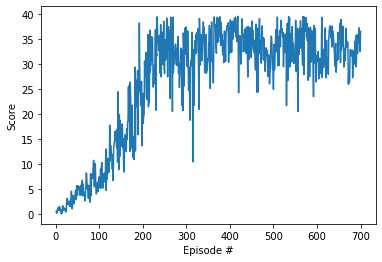

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Aggregated Plot of Rewards

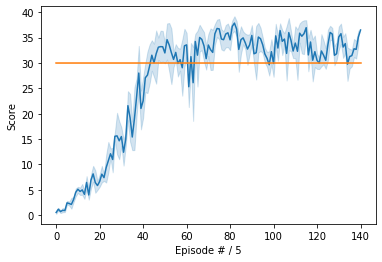

In [22]:
import pandas as pd
data = pd.DataFrame({"episode": np.arange(1, len(scores)+1), "scores" : scores})
data["episode_agg"] = data.episode // 5

fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x="episode_agg", y="scores", data = data)
sns.lineplot(x = "episode_agg", y = 30, data = data)
plt.ylabel('Score')
plt.xlabel('Episode # / 5')
plt.show()

In [ ]:
env.close()